# Exploring Mental Health Data
Source: https://www.kaggle.com/competitions/playground-series-s4e11

Followed this set-up a bit. I like the flow: https://www.kaggle.com/code/oscarm524/ps-s4-ep11-eda-modeling-submission

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
from jax import random

In [77]:
# get data
data_path = Path("~/Data/mental_health/")
train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)
test = pd.read_csv(data_path/ "test.csv", header = 0, index_col = 0)
submission = pd.read_csv(data_path/ "sample_submission.csv")


train.shape, test.shape, submission.shape

((140700, 19), (93800, 18), (93800, 2))

In [78]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [79]:
# Check for missing values
print('--- Percentage of Missing Values in Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Percentage of Missing Values in Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Percentage of Missing Values in Train ---

Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                         

In [80]:
# Check for duplicated rows
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Depression column, there are {sum(train.drop(columns=['Depression'], axis=1).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Depression column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


### Data Exploration ###

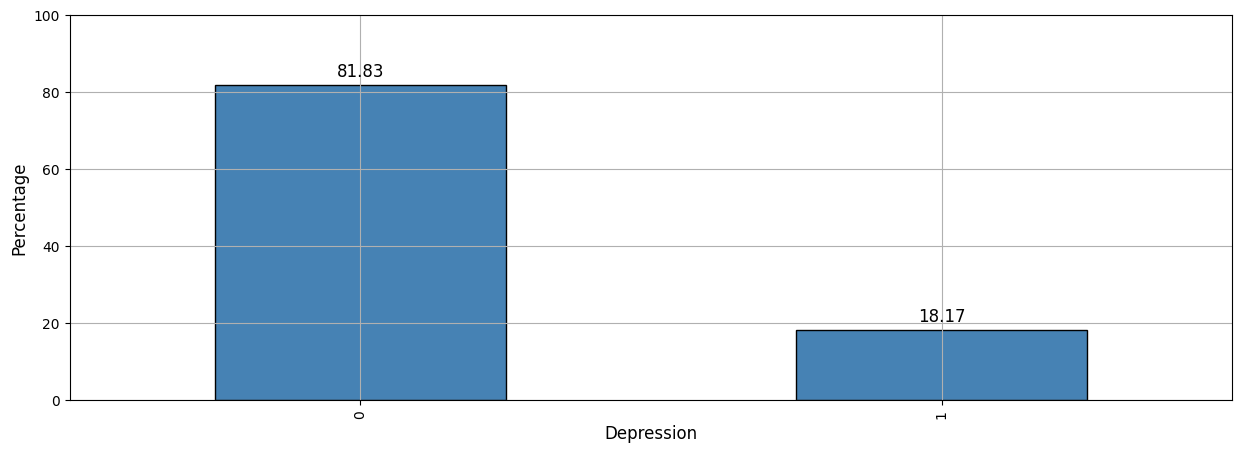

In [81]:
# Plot the distribution of Depression
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = round(train['Depression'].value_counts(normalize=True) * 100, 2).plot(kind='bar', color='steelblue', edgecolor='black')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12, padding=3)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xlabel("Depression", fontsize=12)
ax.set_ylim(0, 100)
ax.grid(True)
plt.show()

# We see that we have an imbalanced dataset. We will need to address this later on.

In [82]:
train.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [83]:
# For the categorical variables, count the number of unique values
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


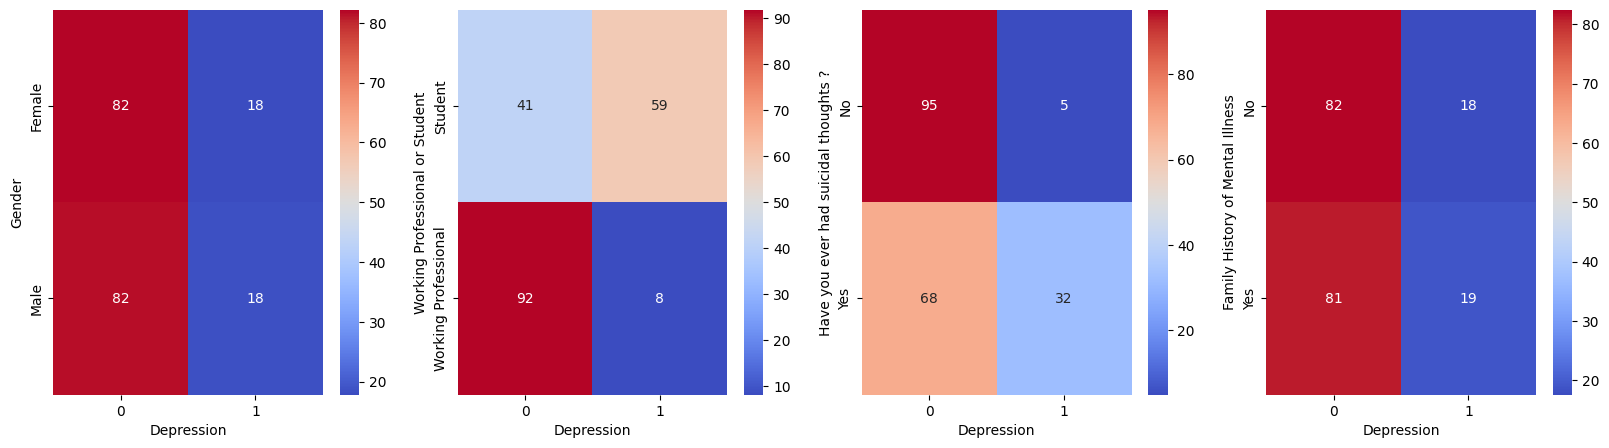

In [84]:
# Look at the relationship between the features and the target variable
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['Gender'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[0])
sns.heatmap(data=round(100*pd.crosstab(train['Working Professional or Student'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[1])
sns.heatmap(data=round(100*pd.crosstab(train["Have you ever had suicidal thoughts ?"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[2])
sns.heatmap(data=round(100*pd.crosstab(train["Family History of Mental Illness"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[3])
plt.show()

In [85]:
train.dtypes

Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

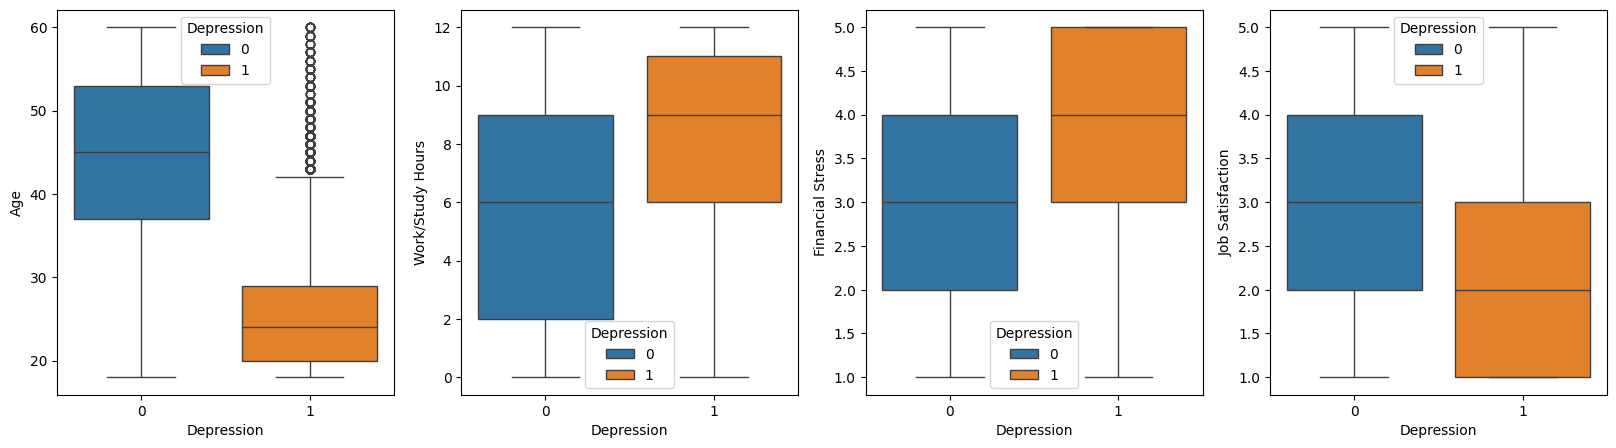

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x='Depression', y='Age', data=train, hue="Depression", ax=ax[0])
sns.boxplot(x='Depression', y='Work/Study Hours', data=train, hue="Depression", ax=ax[1])
sns.boxplot(x='Depression', y='Financial Stress', data=train, hue="Depression", ax=ax[2])
sns.boxplot(x='Depression', y='Job Satisfaction', data=train, hue="Depression", ax=ax[3])
plt.show()

## Create MLP using JAX
Creating a simple fully connected neural network in JAX/FLAX for predicting depression (binary classification)

In [87]:
# Define Neural Network (MLP)
class SimpleMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification

    def setup(self):
        # Define the layers of the MLP
        self.dense1 = nn.Dense(features=self.hidden_size)
        self.dense2 = nn.Dense(features=self.output_size)

    def __call__(self, x):
        # Forward pass through the layers
        x = nn.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [88]:
# Set up Training Loop, Loss Function and Optimizer
def binary_cross_entropy_loss(logits, labels):
    # Compute binary cross-entropy loss
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    loss = -jnp.mean(labels * jnp.log(preds) + (1 - labels) * jnp.log(1 - preds))
    return loss


# Initialize the model and optimizer
def create_model_and_optimizer():
    model = SimpleMLP(hidden_size=64, output_size=1)
    params = model.init(random.PRNGKey(0), jnp.ones((1, 4)))['params']  # Initialize with 4 input features

    # Create Adam optimizer
    learning_rate = 0.001
    optimizer = optax.adam(learning_rate)
    optimizer_state = optimizer.init(params)  # Initialize optimizer state

    return model, params, optimizer, optimizer_state


# Forward pass and loss calculation (no need to pass the model class)
def compute_loss(params, batch, model):
    features, labels = batch
    logits = model.apply({'params': params}, features)  # Get raw logits from the model
    return binary_cross_entropy_loss(logits, labels)

# Training step function (do not pass the model itself)
@jax.jit
def train_step(params, optimizer_state, batch, optimizer, model):
    loss, grads = jax.value_and_grad(compute_loss)(params, batch, model)  # Compute loss and gradients
    updates, optimizer_state = optimizer.update(grads, optimizer_state)  # Update parameters
    params = optax.apply_updates(params, updates)  # Apply updates to the model parameters
    return loss, params, optimizer_state


In [89]:
# Count the number of unique values for each categorical variable
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


In [90]:
# Prepare the data for training
X_train = train.drop(columns=["Name", "City", "Profession", "Sleep Duration", "Dietary Habits", "Degree", "Depression"], axis=1)
y_train = train['Depression']

cat_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

# Combine train and test to ensure consistent one-hot encoding
combined = pd.concat([X_train, test], keys=['train', 'test'])

# One-hot encode the categorical variables
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test sets
X_train = combined.xs('train')
test_selected = combined.xs('test')

# Fill missing values with the mean of the column for numeric columns
X_train = X_train.fillna(X_train.mean())
test_selected = test_selected.fillna(test_selected.mean())

# Ensure all values are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
test_selected = test_selected.apply(pd.to_numeric, errors='coerce')

# Convert data into JAX arrays
X_train = jnp.array(X_train.values)
y_train = jnp.array(y_train.values).reshape(-1, 1)
test_selected = jnp.array(test_selected.values)


/var/folders/bs/gvm42h356mz5vjf9v118br000000gn/T/ipykernel_61973/930279988.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_selected = test_selected.fillna(test_selected.mean())


In [91]:
# Initialize model, optimizer, and parameters
model, params, optimizer, opt_state = create_model_and_optimizer()

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 10 

# Training loop
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train[idx], y_train[idx]

    # Iterate over batches
    for i in range(0, len(X_train), batch_size):
        batch_features = X_train[i:i + batch_size]
        batch_labels = y_train[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, params, opt_state = train_step(model, params, opt_state, batch, optimizer)

    print(f"Epoch {epoch+1}, Loss: {loss}")

TypeError: Error interpreting argument to <function train_step at 0x1694e6a20> as an abstract array. The problematic value is of type <class '__main__.SimpleMLP'> and was passed to the function at path params.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [ ]:
# Predict function
def predict(model, params, X):
    logits = model.apply(params, X)  # Get raw logits
    return jax.nn.sigmoid(logits)  # Apply sigmoid to get probabilities

# Example prediction on new data
X_new = np.random.rand(10, 4)  # 10 new samples
X_new = jnp.array(X_new)

# Get predictions (probabilities)
predictions = predict(model, params, X_new)
print(predictions)
